In [1]:
%config Completer.use_jedi=False

In [2]:
import torch
from torch import nn,optim
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [3]:
class Discriminator(nn.Module):
    def __init__(self,img_dim):
        super(Discriminator,self).__init__()
        self.disc=nn.Sequential(
            nn.Linear(img_dim,128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.disc(x)
    

In [4]:
class Generator(nn.Module):
    def __init__(self,z_dim,img_dim):
        super().__init__()
        self.gen=nn.Sequential(
            nn.Linear(z_dim,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256,img_dim),#28*28*1 -->784
            nn.Tanh()
        )
    def forward(self,x):
        return self.gen(x)

In [24]:
#hyperparmeters
device='cuda' if torch.cuda.is_available() else 'cpu'
lr=1e-3
z_dim=64
image_dim=28*28*1
batch_size=64
num_epochs=15
disc=Discriminator(image_dim).to(device)
gen=Generator(z_dim,image_dim).to(device)
fixed_noise=torch.randn((batch_size,z_dim)).to(device)

transform=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))]
)


In [25]:
dataset=datasets.MNIST(root='dataset/',transform=transform,download=True)

In [26]:
loader=DataLoader(dataset,batch_size=batch_size,shuffle=True)


In [27]:
opt_disc=optim.Adam(disc.parameters(),lr=lr)
opt_gen=optim.Adam(gen.parameters(),lr=lr)
criterion=nn.BCELoss()
writer_fake=SummaryWriter(f'runs/GAN_MNIST/fake')
writer_real=SummaryWriter(f'runs/GAN_MNIST/real')
step=0

In [28]:
losses_G=0
losses_D=0
for epoch in range(num_epochs):
    for batch_idx,(real,_) in enumerate(tqdm(loader)):
        real=real.view(-1,784).to(device)
        batch_size=real.shape[0]
        #train DiScriminator:max log(D(real))+log(1-D(G(z)))
        noise=torch.randn((batch_size,z_dim)).to(device)
        fake=gen(noise)
        disc_real=disc(real).view(-1)
        lossD_real=criterion(disc_real,torch.ones_like(disc_real))
        disc_fake=disc(fake).view(-1)
        lossD_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
        lossD=(lossD_real+lossD_fake)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        #train the generator min log(1-D(G(z))) --> max log(D(G(z))) better
        output=disc(fake).view(-1)
        lossG=criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        losses_G+=lossG.item()
        losses_D+=lossD.item()
        #tensorboard
        if batch_idx==0:
            with torch.no_grad():
                fake=gen(fixed_noise).reshape(-1,1,28,28)
                data=real.reshape(-1,1,28,28)
                img_grid_fake=torchvision.utils.make_grid(fake,normalize=True)
                img_grid_real=torchvision.utils.make_grid(data,normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Image each batch",img_grid_fake,global_step=step
                )
                writer_real.add_image(
                    "Mnist real Image each batch",img_grid_real,global_step=step
                )
                
                step+=1
    writer_fake.add_scalar('loss_discriminator each epoch',losses_D/len(loader),epoch)
    writer_fake.add_scalar('loss_generator each epoch',losses_G/len(loader),epoch)
    print(f"epoch [{epoch}/{num_epochs}]  losses_D :{losses_D/len(loader)} , losses_G :{losses_G/len(loader)}")
    losses_G,losses_D=0,0
writer_fake.close()
writer_real.close()

100%|██████████| 938/938 [00:24<00:00, 38.24it/s]


epoch [0/15]  losses_D :0.25894309612098276 , losses_G :3.359576360884506


100%|██████████| 938/938 [00:23<00:00, 40.62it/s]


epoch [1/15]  losses_D :0.3456294002658777 , losses_G :4.109197974840461


100%|██████████| 938/938 [00:21<00:00, 42.78it/s]


epoch [2/15]  losses_D :0.6223759645465087 , losses_G :2.4143968673148897


100%|██████████| 938/938 [00:21<00:00, 44.07it/s]


epoch [3/15]  losses_D :0.7536386066376527 , losses_G :2.3296842481345257


100%|██████████| 938/938 [00:20<00:00, 45.71it/s]


epoch [4/15]  losses_D :0.8253460463398555 , losses_G :1.6097955807312718


100%|██████████| 938/938 [00:20<00:00, 45.82it/s]


epoch [5/15]  losses_D :0.8718133852648329 , losses_G :1.3905085399270312


100%|██████████| 938/938 [00:20<00:00, 46.19it/s]


epoch [6/15]  losses_D :0.8082159505342879 , losses_G :1.3209548399551336


100%|██████████| 938/938 [00:20<00:00, 45.80it/s]


epoch [7/15]  losses_D :0.748699542413007 , losses_G :1.5178669660584505


100%|██████████| 938/938 [00:20<00:00, 45.84it/s]


epoch [8/15]  losses_D :0.7583277074735302 , losses_G :1.4191706808708877


100%|██████████| 938/938 [00:20<00:00, 45.57it/s]


epoch [9/15]  losses_D :0.8467484735794413 , losses_G :1.3303535369667672


100%|██████████| 938/938 [00:20<00:00, 45.30it/s]


epoch [10/15]  losses_D :0.7742012835769002 , losses_G :1.4768450786945408


100%|██████████| 938/938 [00:20<00:00, 45.82it/s]


epoch [11/15]  losses_D :0.6955195752733043 , losses_G :1.5048543481684442


100%|██████████| 938/938 [00:20<00:00, 45.50it/s]


epoch [12/15]  losses_D :0.6987159221347715 , losses_G :1.5516300155028606


100%|██████████| 938/938 [00:20<00:00, 45.72it/s]


epoch [13/15]  losses_D :0.7027129729482919 , losses_G :1.609295426210615


100%|██████████| 938/938 [00:20<00:00, 45.97it/s]

epoch [14/15]  losses_D :0.7371833206239794 , losses_G :1.3644715144690165


1875

In [12]:
from matplotlib import pyplot as plt

In [ ]:
# for epoch in range(num_epochs):
#     for batch_idx, (real, _) in enumerate(tqdm(loader)):
#         real = real.view(-1, 784).to(device)
#         batch_size = real.shape[0]

#         ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
#         noise = torch.randn(batch_size, z_dim).to(device)
#         fake = gen(noise)
#         disc_real = disc(real).view(-1)
#         lossD_real = criterion(disc_real, torch.ones_like(disc_real))
#         disc_fake = disc(fake).view(-1)
#         lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
#         lossD = (lossD_real + lossD_fake) / 2
#         disc.zero_grad()
#         lossD.backward(retain_graph=True)
#         opt_disc.step()

#         ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
#         # where the second option of maximizing doesn't suffer from
#         # saturating gradients
#         output = disc(fake).view(-1)
#         lossG = criterion(output, torch.ones_like(output))
#         gen.zero_grad()
#         lossG.backward()
#         opt_gen.step()


 14%|█▍        | 269/1875 [00:04<00:28, 56.87it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/abdo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-0de646b648ac>", line 2, in <module>
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
  File "/home/abdo/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1185, in __iter__
    for obj in iterable:
  File "/home/abdo/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 435, in __next__
    data = self._next_data()
  File "/home/abdo/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 475, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/abdo/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/abdo/anaconda3/lib/python3.7/site-package

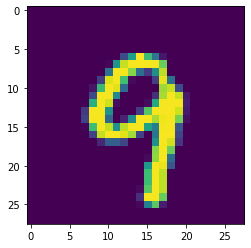

In [15]:
plt.imshow(loader.dataset.data[550])

In [13]:
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [30]:
from torch.utils.data import dataloader

ERROR! Session/line number was not unique in database. History logging moved to new session 737


In [14]:
bb=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)

ERROR! Session/line number was not unique in database. History logging moved to new session 743


In [15]:
((iter(bb)).next())

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -